# Trabajo Final de Aprendizaje de Máquina

### Walmart Recruiting: Trip Type Classification


**J. Adrián Sánchez Castro**   116369<br>
**Nohemí Limnones Calvillo**    136135<br>
**Manuel Ríos Zagal**           159284<br>


#### Diciembre, 2016

Instituto Tecnológico Autónomo de México

## Introducción

<img src="walmart.png"/>

El proyecto final consiste en clasificar tipos de viajes de compras basándose en los artículos que compraron los clientes. Para dar algunos ejemplos hipotéticos de tipos de viaje: un cliente puede hacer un pequeño viaje diario para la cena, un viaje semanal para compra de muchos comestibles, un viaje para comprar regalos para unas próximas vacaciones, o un viaje temporada para comprar ropa.

Walmart ha categorizado los viajes contenidos en estos datos en 38 distintos tipos usando un método patentado aplicado a un conjunto extendido de datos. Se le reta a recrear esta categorización / agrupación con un conjunto más limitado de características.


Para resolver el proyecto se utilizarán 3 algoritmos de aprendizaje máquina: Regresión Logística, Bosques Aleatorios y K-Vecinos Cercanos. El objetivo es tratar de lograr el mayor porcentaje de certeza en la predicción del tipo de viaje.

Este proyecto es entregado en un *Ipython Jupyter Notebook* que se encuentra dividido en cuatro secciones.

- **Sección 1.** Análisis Exploratorio de Datos
- **Sección 2.** Limpieza y Transformación de Datos<br>
<ul>
<li>Train</li>
<li>Test</li>
</ul>
- **Sección 3.** Modelos
<ul>
<li>Cross-Validation</li>
<li>Regresión Logística</li>
<li>KNN & PCA</li>
<li>Random Forest</li>
</ul>                    
- **Sección 4.** Análisis de Resultados

## Importación de modulos

In [1]:
import re
import scipy
import sklearn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

## Sección 1. Análisis exploratorio de datos en base de entrenamiento

In [2]:
#Primero leemos los datos en un pandas Data Frame
data = pd.read_csv("data/train.csv")
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [3]:
#Mostramos el shape del pandas que acabamos que abrir
data.shape

(647054, 7)

Podemos observar que en el data frame de entrenamiento, tenemos <b>647,054</b> observaciones y <b>7</b> variables que representan nuestra variable a predecir y nuestros features.

Las variables segun la competencia son:
<ul>
<li>TripType - una identificación categórica que representa el tipo de viaje de compras realizado por el cliente. TripType = 999 es la categoría "otro". <b>Esta es nuestra variable a predecir.</b></li>
<li>VisitNumber - un id que corresponde a un solo viaje de un solo cliente.</li>
<li>Día de la semana - el día de la semana del viaje.</li>
<li>UPC - el número de UPC del producto comprado.</li>
<li>ScanCount: el número de artículos que se adquirió. Un valor negativo indica un retorno del producto.</li>
<li>DepartamentDescription - una descripción de alto nivel del departamento del artículo.</li>
<li>FinelineNumber - una categoría más refinada para cada uno de los productos, creada por Walmart.</li>
</ul>


#### Contando valores en nuestra base

In [4]:
#Aplicamos el metodo de count
data.count()

TripType                 647054
VisitNumber              647054
Weekday                  647054
Upc                      642925
ScanCount                647054
DepartmentDescription    645693
FinelineNumber           642925
dtype: int64

Podemos ver que la mayoria de las variables cuenta con 647,054 observaciones, a excepcion de la variable de Fineline Number que cuenta con 642,925. Esto representa **4,129** observaciones menos en esta variable debido a que cuenta con **NA´s**. Si calculamos el porcentaje de NA´s:

In [5]:
#Sacamos la diferencia para ver cuantos NA´s tenemos
print(647054-642925)

#Si sacamos el porcentaje
print(4129/647054)

4129
0.006381229387346342



Podemos ver que las **4129** filas que se encuentran **vacías ** representan alrededor del **0.6%** del total de la base. Al ser pocas variables del total, las podemos remover sin afectar la base.

#### Remover los NA's

In [6]:
#Removemos NA´s
data = data.dropna()

In [7]:
#Contamos de nuevo nuestra base
data.count()

TripType                 642925
VisitNumber              642925
Weekday                  642925
Upc                      642925
ScanCount                642925
DepartmentDescription    642925
FinelineNumber           642925
dtype: int64

In [8]:
#Imprimimos de nuevo el shape del datafram
data.shape

(642925, 7)

Aqui podemos ver que hemos removido las 4,129 de la base.

#### Tipos de visitas

In [9]:
#Tipos de visitas = 38 tipos de visitas diferentes
len(data.TripType.unique())

38

In [10]:
#Sort
x = data.TripType.unique()
np.sort(x)

array([  3,   4,   5,   6,   7,   8,   9,  12,  14,  15,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999])

Recordemos que teníamos **38 tipos de visitas**. Nos interesaría saber qúe tipo de visitas son las **más populares**. O también, nos interesaría saber si las visitas están **distribuidas uniformemente**.

In [11]:
#Graficando el tipo de visita mas popular, primero nos quedamos solo con cualquier producto
#del ticket total
df_tipo_visita = data.drop_duplicates("VisitNumber")

In [12]:
#Separamos la columna del tipo de visita
x = df_tipo_visita["TripType"]
x = x.value_counts()

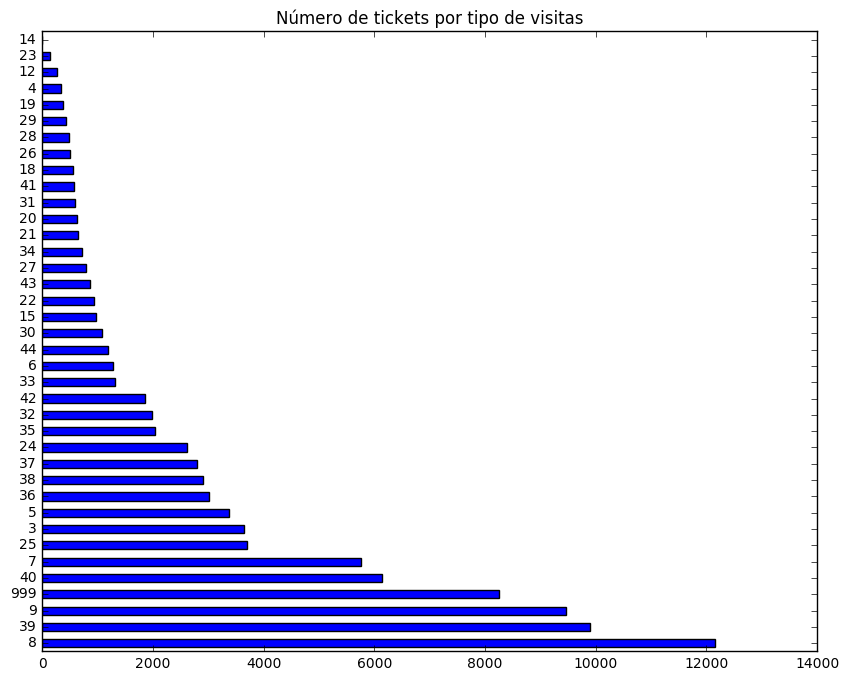

In [13]:
#Graficamos
graph = x.plot(kind="barh", figsize=(10, 8))
graph.set_title("Número de tickets por tipo de visitas")

Podemos ver que alrededor de **6 tipos** de tipos de visita contienen la mayoría de visitas. Que serían el 7, 40, 999, 9, 39, y 8

#### Número de visitas

In [14]:
#Imprimos los valores unicos del numero de visita = 94247. 
#Este es el numero de clientes/tickets que hay en la base
len(data.VisitNumber.unique())

94247

#### Número de compras

In [15]:
#Contamos el numero de compras
h = data.ScanCount.unique()
h[::-1].sort()
h

array([ 71,  51,  46,  31,  30,  25,  24,  23,  22,  20,  19,  18,  17,
        16,  15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,
         3,   2,   1,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -9, -10, -12])

Scan Count dice la cantidad de productos comprados. Podemos ver que existen **valores negativos** que implican productos devueltos. Hay un producto que fue comprado 71 veces en una sola visita, y también hay un producto que fue devuelto 12 veces.

#### Tipos de departamento

In [16]:
data.DepartmentDescription.unique()

array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP',
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEAR',
    

Estas son las clasificaciones que Walmart tiene asignadas a a cada producto. Corresponde al tipo de departamento al que pertenece el producto dentro de algun Wal-Mart.

In [17]:
len(data.DepartmentDescription.unique())

68

Vemos que hay **68** departamento diferentes para clasificar a los productos.

#### Número de productos

In [18]:
#Imprimimos el numero de UPC´s(Codigo de barras)
len(data.Upc.unique())

97714

Vemos que existen alrededor de **97,714** codigos de barras diferentes en la base.

#### Categorías para productos

In [19]:
len(data.FinelineNumber.unique())

5195

Fineline Number corresponde a una categoria asignada por Wal-Mart. Hay **5,196** categorias asignadas para 97,715 productos.

### Anáisis del tipo de visita y producto

1. Nos interesaría entender que **tipo de productos compran por visita**.

Vemos que el **tipo de visita 9** corresponde a **qué tipo de productos** basados en su departamento.

In [20]:
#Separamos el tipo de visita 9
tipo_visita_9 = data[data.TripType == 9]

In [21]:
#Nos quedamos con los departamentos de los que se compraron productos durante alguna visita = 9
tipo_visita_9_departamento = tipo_visita_9[["TripType","DepartmentDescription"]]
tipo_visita_9_departamento.head()

,TripType,DepartmentDescription
66,9,PRODUCE
67,9,HOME MANAGEMENT
89,9,LADIESWEAR
116,9,MENS WEAR
143,9,MENS WEAR


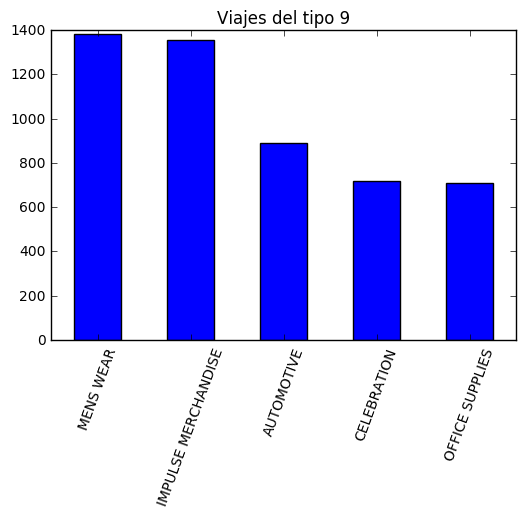

In [22]:
#Graficamos cuales son los departamentos de donde más productos se compran si la visita = 9
tipo_visita_9_departamento.DepartmentDescription.value_counts().head().plot(kind="bar", rot=70, title="Viajes del tipo 9")

Podemos ver que la visita esta muy ligado a diversos tipos de productos, este tipo de analisis no funciona mucho para entender que tipo de productos que hay en cada visita. Eso se lo dejaremos a nuestros modelos.

## Sección 2. Limpieza y Transformación de Datos

### Train Set

Vamos a importar y cambiar el nombre de las columnas en la base de entrenamiento. Al **numero de visita** la llamaremos ahora **ticket** para facilitar el análisis. Podemos ver que un ticket puede contener diversos productos.

In [23]:
#Importamos la base con pandas Data Frame para el conjunto de entrenamiento
train = pd.read_csv("data/train.csv")
#Cambiamos el nombre de las columnas a español
train.columns = ['tipo_visita', 'ticket', 'dia', 'producto', 'items_comprados',
                 'departamento', 'categoria']
#Imprimimos el head de la base
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [24]:
#Imprimos el shape: 647,054 observaciones de 7 columnas
train.shape

(647054, 7)

#### Removemos los NA's

In [25]:
#Removemos los NA´s. Vemos que quedamos con 4,129 filas menos.
train = train.dropna()
train.shape

(642925, 7)

#### Creamos "dummies" por departamento

Vamos a crear variabes dummies por departamento, cada una en una columna diferente. Esta variable creemos es importante para clasificar el tipo de viaje.

In [26]:
#Creamos dummies de cada tipo de producto definido por el departamento
dummies_train = pd.get_dummies(train.departamento)
dummies_train.head()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Tenemos 68 columnas que corresponde a cada tipo de departamento
dummies_train.shape

(642925, 68)

In [28]:
#Unimos estas dummies a nuestra base de entrenamiento e imprimimos el head
train[dummies_train.columns] = dummies_train 
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creamos dummies por dia.

Vamos a convertir los dias en variables numericas, en este caso lo mantendremos en la misma columna.

In [29]:
dia = ["Monday","Tuesday","Wednesday","Thursday", "Friday", "Saturday", "Sunday"]
train.dia = train.dia.astype("category", ordered=True, categories = dia).cat.codes
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,999,5,4,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,7,4,6.053882e+10,1,SHOES,8931.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,30,7,4,7.410811e+09,1,PERSONAL CARE,4504.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,8,4,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,8,4,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos que la columna de **dia** ahora esta representada por numeros. Representando el **0** al dia **Lunes** y asi sucesivamente.

#### Creando dummie de "devolucion"

Vamos a crear una columna nueva de tipo dummie, esta nos dice si ese viaje hubo alguna devolucion de producto **(devolucion = 1)** o si no.

In [30]:
#Creando dummie especial si hubo algun retorno de producto
train.loc[train.items_comprados < 0, 'devolucion'] = 1
train.loc[train.devolucion != 1, 'devolucion'] = 0
train.head()

,tipo_visita,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,devolucion
0,999,5,4,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,30,7,4,6.053882e+10,1,SHOES,8931.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,7,4,7.410811e+09,1,PERSONAL CARE,4504.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,8,4,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,8,4,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos que ya tenemos una columna de nombre **devolucion** con valores **0** o **1**.

#### Total de productos por departamento por ticket

Vamos a contar cuantos productos se compraron de cada departamento, en cada ticket.

In [31]:
#Creación de un dataframe que ligue las categorias de producto por ticket,
#utilizamos nuestras dummies por departamento.
dummies_train.head()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#Vamos a multiplicar el numero de productos por la dummies de departamento para sacar el total
dummies_train = dummies_train.apply(lambda x: x*train["items_comprados"])
dummies_train = dummies_train.replace(-0,0)
dummies_train.describe()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,...,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000,642925.000000
mean,0.000705,0.001935,0.008502,0.012916,0.007623,0.023451,0.003689,0.001526,0.005716,0.002708,...,0.003425,0.000042,0.016762,0.000827,0.008951,0.003430,0.008001,0.000919,0.009659,0.002489
std,0.038088,0.051112,0.114137,0.139105,0.107961,0.176328,0.080005,0.043659,0.083587,0.059555,...,0.070268,0.006716,0.142865,0.042906,0.120048,0.068394,0.117212,0.037006,0.125919,0.058470
min,-2.000000,-2.000000,-6.000000,-6.000000,-3.000000,-9.000000,-2.000000,-2.000000,-3.000000,-3.000000,...,-1.000000,-1.000000,-2.000000,-2.000000,-3.000000,-2.000000,-5.000000,-1.000000,-10.000000,-2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,9.000000,12.000000,12.000000,10.000000,20.000000,12.000000,7.000000,4.000000,4.000000,...,11.000000,1.000000,7.000000,10.000000,51.000000,15.000000,20.000000,2.000000,16.000000,4.000000


#### Concatenar base con dummies por departamento

In [33]:
#Nos deshacemos de la columna del codigo de barras y de las dummies creadas por departamento
#Estan seran cambiadas por las dummies que traen el total de productos por departamento
train = train[["tipo_visita", "ticket", "dia", "items_comprados", "devolucion"]]

In [34]:
#Vamos a concatenar nuestra base de train con la nueva columna de devolucion y las dummies 
train = pd.concat([train, dummies_train], axis=1)
train.head()

,tipo_visita,ticket,dia,items_comprados,devolucion,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,999,5,4,-1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,7,4,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,30,7,4,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,26,8,4,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26,8,4,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos que terminamos con **73** columnas en nuestra base de entrenamiento

#### Agrupamiento por ticket por tipo de producto por departamento

In [35]:
#Vamos a agrupar por ticket para poder pasar nuestros datos de un formato "long" a uno "wide"
grouped = train.groupby("ticket")

In [36]:
#Vamos a definir que queremos que nos regrese en cada columna y su nombre
#En algunas columnas necesitamos la suma mientras en otra solo el valor máximo.
grouped = grouped.agg({'dia': np.max, "tipo_visita": np.max, 'items_comprados': np.sum, 'devolucion': np.max, 
              '1-HR PHOTO': np.sum, 'ACCESSORIES': np.sum,
       'AUTOMOTIVE': np.sum, 'BAKERY': np.sum, 'BATH AND SHOWER': np.sum, 'BEAUTY': np.sum, 'BEDDING': np.sum,
       'BOOKS AND MAGAZINES': np.sum, 'BOYS WEAR': np.sum, 'BRAS & SHAPEWEAR': np.sum,
       'CAMERAS AND SUPPLIES': np.sum, 'CANDY, TOBACCO, COOKIES': np.sum, 'CELEBRATION': np.sum,
       'COMM BREAD': np.sum, 'CONCEPT STORES': np.sum, 'COOK AND DINE': np.sum, 'DAIRY': np.sum, 'DSD GROCERY': np.sum,
       'ELECTRONICS': np.sum, 'FABRICS AND CRAFTS': np.sum, 'FINANCIAL SERVICES': np.sum,
       'FROZEN FOODS': np.sum, 'FURNITURE': np.sum, 'GIRLS WEAR, 4-6X  AND 7-14': np.sum,
       'GROCERY DRY GOODS': np.sum, 'HARDWARE': np.sum, 'HOME DECOR': np.sum,
       'HOME MANAGEMENT': np.sum, 'HORTICULTURE AND ACCESS': np.sum,
       'HOUSEHOLD CHEMICALS/SUPP': np.sum, 'HOUSEHOLD PAPER GOODS': np.sum,
       'IMPULSE MERCHANDISE': np.sum, 'INFANT APPAREL': np.sum, 'INFANT CONSUMABLE HARDLINES': np.sum,
       'JEWELRY AND SUNGLASSES': np.sum, 'LADIES SOCKS': np.sum, 'LADIESWEAR': np.sum,
       'LARGE HOUSEHOLD GOODS': np.sum, 'LAWN AND GARDEN': np.sum, 'LIQUOR,WINE,BEER': np.sum,
       'MEAT - FRESH & FROZEN': np.sum, 'MEDIA AND GAMING': np.sum, 'MENS WEAR': np.sum, 'MENSWEAR': np.sum,
       'OFFICE SUPPLIES': np.sum, 'OPTICAL - FRAMES': np.sum, 'OPTICAL - LENSES': np.sum,
       'OTHER DEPARTMENTS': np.sum, 'PAINT AND ACCESSORIES': np.sum, 'PERSONAL CARE': np.sum,
       'PETS AND SUPPLIES': np.sum, 'PHARMACY OTC': np.sum, 'PHARMACY RX': np.sum,
       'PLAYERS AND ELECTRONICS': np.sum, 'PLUS AND MATERNITY': np.sum, 'PRE PACKED DELI': np.sum,
       'PRODUCE': np.sum, 'SEAFOOD': np.sum, 'SEASONAL': np.sum, 'SERVICE DELI': np.sum, 'SHEER HOSIERY': np.sum,
       'SHOES': np.sum, 'SLEEPWEAR/FOUNDATIONS': np.sum, 'SPORTING GOODS': np.sum,
       'SWIMWEAR/OUTERWEAR': np.sum, 'TOYS': np.sum, 'WIRELESS': np.sum})

In [37]:
#Debido a que no vamos a usar todas nuestras columnas, vamos a seleccionar algunas de estas
train = grouped[["tipo_visita", "dia", "items_comprados", "devolucion", 'ACCESSORIES',
               'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
               'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
               'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
               'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
               'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
               'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
               'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
               'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
               'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
               'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
               'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
               'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
               'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR',
               'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
               'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
               'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
               'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
               'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
               'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
               'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']]

In [38]:
train.head(5)

,tipo_visita,dia,items_comprados,devolucion,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
ticket,,,,,,,,,,,,,,,,,,,,,
5,999,4,-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,30,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,26,4,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8,4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,8,4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


De esta manera, tenemos un dataframe que agrupo por cada **id de ticket** con el **tipo de viaje** y el **numero de productos por departamento** que compro.

#### Creando dummie por tipo de visita

In [39]:
train.tipo_visita = train.tipo_visita.astype("category").cat.codes

/Users/marz/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### Creando columna de suma de categorias

Esta columna que vamos a crear, indica la suma de cuantos departametno se vieron involucrados en la compra por ticket. Para eso vamos a usar la siguiente funcion:

In [40]:
def category_count_train(data):
    """# Para cada fila a partir de la columna 4, 
    suma uno por cada tipo de producto comprado en una lista y lo apendea en una lista
    """
    alist = []
    for array in np.asarray(data.iloc[:,4:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"total_tipo_productos"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(4, 'total_categorias_compradas', cat_counts)
    
    return data

In [41]:
#Aplicamos la funcion a la base
train = category_count_train(train)
train.head()

,tipo_visita,dia,items_comprados,devolucion,total_categorias_compradas,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
ticket,,,,,,,,,,,,,,,,,,,,,
5,37,4,-1,1.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22,4,2,0.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,18,4,27,1.0,6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5,4,3,0.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5,4,3,0.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Terminanos con un conjunto de entrenamiento de 71 columnas.

De esta manera terminamos el **"feature engineering"** a nuestro conjunto de entrenamiento. Realizaremos lo mismo al conjunto de prueba antes de pasar al modelado.

### Test Set

Vamos a realiza el mismo proceso de **feature engineering** para el set de test. En este caso no nos detendremos tanto en explicar. En esta base no borraremos los **NA´s** ya que tenemos que subir la base con el mismo numero de filas a Kaggle.

In [42]:
#Importamos la base con pandas Data Frame para el conjunto de prueba
test = pd.read_csv("data/test.csv")
#Cambiamos el nombre de las columnas
test.columns = ['ticket', 'dia', 'producto', 'items_comprados', 'departamento', 'categoria']
#Imprimimos el head
test.head()

,ticket,dia,producto,items_comprados,departamento,categoria
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


In [43]:
#Creamos dummies de cada tipo de producto definido por el departamento
dummies_test = pd.get_dummies(test.departamento)
test[dummies_test.columns] = dummies_test 
test.head()

,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,1,Friday,7.250339e+10,1,SHOES,3002.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creamos dummies por dia.

In [44]:
test['dia'] = test['dia'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7})
test.head()

,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,1,5,7.250339e+10,1,SHOES,3002.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,5,1.707711e+09,1,DAIRY,1526.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,8.947000e+10,1,DAIRY,1431.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,5,8.849121e+10,1,GROCERY DRY GOODS,3555.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,5,2.840015e+09,1,DSD GROCERY,4408.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#Creación de un dataframe que ligue las categorias de producto por ticket
data_dummies_test = test.iloc[:,6:]
data_dummies_test.head()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
data_dummies_test = data_dummies_test.apply(lambda x: x*test["items_comprados"])
data_dummies_test = data_dummies_test.replace(-0,0)
data_dummies_test.describe()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,...,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000,653646.000000
mean,0.000704,0.002035,0.008465,0.012585,0.007539,0.023510,0.003488,0.001388,0.005783,0.002613,...,0.003739,0.000046,0.016336,0.000944,0.008908,0.003540,0.007773,0.000938,0.009548,0.002408
std,0.046142,0.052757,0.117342,0.135384,0.109231,0.173454,0.076787,0.040113,0.085319,0.058403,...,0.073684,0.010048,0.142642,0.050884,0.102109,0.069109,0.110972,0.036909,0.124867,0.059630
min,-6.000000,-8.000000,-3.000000,-2.000000,-5.000000,-14.000000,-6.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-3.000000,-4.000000,-7.000000,-3.000000,-2.000000,-4.000000,-1.000000,-3.000000,-2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.000000,7.000000,16.000000,13.000000,19.000000,12.000000,12.000000,4.000000,12.000000,4.000000,...,13.000000,3.000000,6.000000,18.000000,6.000000,14.000000,11.000000,2.000000,20.000000,10.000000


#### Creando dummie de "devolucion"

In [47]:
#Creando dummie especial si hubo algun retorno de producto
test.loc[test.items_comprados < 0, 'devolucion'] = 1
test.loc[test.devolucion != 1, 'devolucion'] = 0
test.head()

,ticket,dia,producto,items_comprados,departamento,categoria,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,devolucion
0,1,5,7.250339e+10,1,SHOES,3002.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,1.707711e+09,1,DAIRY,1526.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,8.947000e+10,1,DAIRY,1431.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,5,8.849121e+10,1,GROCERY DRY GOODS,3555.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,5,2.840015e+09,1,DSD GROCERY,4408.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Concatenar base con dummies por departamento

In [48]:
#Nos deshacemos de la columna del codigo de barras y de las dummies creadas por departamento
#Estan seran cambiadas por las dummies que traen el total de productos por departamento
test = test[["ticket", "dia", "items_comprados", "devolucion"]]

In [49]:
#Vamos a concatenar nuestra base de train con la nueva columna de devolucion y las dummies 
test = pd.concat([test, data_dummies_test], axis=1)
test.head()

,ticket,dia,items_comprados,devolucion,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
0,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Agrupamiento por ticket por tipo de producto por departamento

In [50]:
grouped = test.groupby("ticket")

In [51]:
grouped = grouped.agg({'dia': np.max, 'items_comprados': np.sum, 'devolucion': np.max,'1-HR PHOTO': np.sum, 'ACCESSORIES': np.sum,
       'AUTOMOTIVE': np.sum, 'BAKERY': np.sum, 'BATH AND SHOWER': np.sum, 'BEAUTY': np.sum, 'BEDDING': np.sum,
       'BOOKS AND MAGAZINES': np.sum, 'BOYS WEAR': np.sum, 'BRAS & SHAPEWEAR': np.sum,
       'CAMERAS AND SUPPLIES': np.sum, 'CANDY, TOBACCO, COOKIES': np.sum, 'CELEBRATION': np.sum,
       'COMM BREAD': np.sum, 'CONCEPT STORES': np.sum, 'COOK AND DINE': np.sum, 'DAIRY': np.sum, 'DSD GROCERY': np.sum,
       'ELECTRONICS': np.sum, 'FABRICS AND CRAFTS': np.sum, 'FINANCIAL SERVICES': np.sum,
       'FROZEN FOODS': np.sum, 'FURNITURE': np.sum, 'GIRLS WEAR, 4-6X  AND 7-14': np.sum,
       'GROCERY DRY GOODS': np.sum, 'HARDWARE': np.sum, 'HOME DECOR': np.sum,
       'HOME MANAGEMENT': np.sum, 'HORTICULTURE AND ACCESS': np.sum,
       'HOUSEHOLD CHEMICALS/SUPP': np.sum, 'HOUSEHOLD PAPER GOODS': np.sum,
       'IMPULSE MERCHANDISE': np.sum, 'INFANT APPAREL': np.sum, 'INFANT CONSUMABLE HARDLINES': np.sum,
       'JEWELRY AND SUNGLASSES': np.sum, 'LADIES SOCKS': np.sum, 'LADIESWEAR': np.sum,
       'LARGE HOUSEHOLD GOODS': np.sum, 'LAWN AND GARDEN': np.sum, 'LIQUOR,WINE,BEER': np.sum,
       'MEAT - FRESH & FROZEN': np.sum, 'MEDIA AND GAMING': np.sum, 'MENS WEAR': np.sum, 'MENSWEAR': np.sum,
       'OFFICE SUPPLIES': np.sum, 'OPTICAL - FRAMES': np.sum, 'OPTICAL - LENSES': np.sum,
       'OTHER DEPARTMENTS': np.sum, 'PAINT AND ACCESSORIES': np.sum, 'PERSONAL CARE': np.sum,
       'PETS AND SUPPLIES': np.sum, 'PHARMACY OTC': np.sum, 'PHARMACY RX': np.sum,
       'PLAYERS AND ELECTRONICS': np.sum, 'PLUS AND MATERNITY': np.sum, 'PRE PACKED DELI': np.sum,
       'PRODUCE': np.sum, 'SEAFOOD': np.sum, 'SEASONAL': np.sum, 'SERVICE DELI': np.sum, 'SHEER HOSIERY': np.sum,
       'SHOES': np.sum, 'SLEEPWEAR/FOUNDATIONS': np.sum, 'SPORTING GOODS': np.sum,
       'SWIMWEAR/OUTERWEAR': np.sum, 'TOYS': np.sum, 'WIRELESS': np.sum})

In [52]:
test = grouped[["dia", "items_comprados", "devolucion", 'ACCESSORIES',
               'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
               'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
               'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
               'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
               'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
               'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
               'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
               'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
               'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
               'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
               'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
               'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
               'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR',
               'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
               'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
               'PETS AND SUPPLIES', 'PHARMACY OTC', 'PHARMACY RX',
               'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
               'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
               'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
               'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']]

#### Creando columna de suma de categorias

In [53]:
def category_count_test(data):
    """# Para cada fila a partir de la columna 4, 
    suma uno por cada tipo de producto comprado en una lista y lo apendea en una lista
    """
    alist = []
    for array in np.asarray(data.iloc[:,3:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"total_tipo_productos"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'total_categorias_compradas', cat_counts)
    
    return data

In [54]:
#Aplicamos la funcion para contar categoria
test = category_count_test(test)

In [55]:
print(test.shape)
test.head()

(95674, 70)


,dia,items_comprados,devolucion,total_categorias_compradas,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
ticket,,,,,,,,,,,,,,,,,,,,,
1,5,4,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,5,4,0.0,3,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Terminanos con un conjunto de entrenamiento de **70** columnas.

En este caso, la tabla de **test** queda con una columna menos que la de train. Esa columna menos es la columna qu tenemos que predecir con nuestros modelos.

## Sección 3. Modelos

### Hold-Out Cross Validation

Vamos a hacer **cross-validation** con nuestro set de train. Asi podremos revisar la precision de nuestro modelo antes de predecir en el test original y subir nuestros resultados a Kaggle. Vamos a separar nuestro train en: train:70% y test:30%

In [56]:
from sklearn.cross_validation import train_test_split

/Users/marz/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [57]:
#Separamos la base de datos original de train en train y test nuevamente 
train_2,test_2 = train_test_split(train, test_size=0.3)

In [58]:
#Vamos a separar las variables explicativas(x`s) y la variable a predecir(y) en las dos bases

#Base de train
y_train = train_2["tipo_visita"]
x_train = train_2.drop("tipo_visita", axis=1).values.astype(float)

#Base de test
y_test = test_2["tipo_visita"]
x_test = test_2.drop("tipo_visita", axis=1).values.astype(float)

Estas bases creadas seran las que usaremos de ahora adelante en los modelos.

### Regresión Logística

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [60]:
#Vamos a plicar regresion logistica y predecimos en cross-validation
#A este modelo lo llamaremos modelo_1
LR = LogisticRegression()
LR.fit(X = np.asarray(x_train), y = np.asarray(y_train))

pred_prob = LR.predict_proba(np.asarray(x_test))
pred_noprob = LR.predict(np.asarray(x_test))

print("Porcentaje de Pérdida Logarítmica: {}".format(log_loss(y_test, pred_prob).round(5)))
print("Resultado de Precisión del Modelo: {}".format(accuracy_score(y_test, pred_noprob)))

Porcentaje de Pérdida Logarítmica: 1.2972
Resultado de Precisión del Modelo: 0.6398231653404067


Podemos ver que nuestro modelo de regresion logistica tiene una precision de **~64%** en el cross-validation.

### Bosques Aleatorios

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
bosque = RandomForestClassifier(n_estimators = 300, max_features=2)

In [63]:
bosque = bosque.fit(np.asarray(x_train), np.asarray(y_train))

In [64]:
predicciones = bosque.predict_proba(np.asarray(x_test))
predicciones_noProba = bosque.predict(np.asarray(x_test))

print("Porcentaje de Pérdida Logarítmica: {}".format(log_loss(y_test, predicciones).round(5)))
print("Resultado de Precisión del Modelo: {}".format(sklearn.metrics.accuracy_score(y_test, predicciones_noProba)))

Porcentaje de Pérdida Logarítmica: 1.3887
Resultado de Precisión del Modelo: 0.6710875331564987


Podemos ver que nuestro modelo de bosques aleatorios tiene una precision de **~67%** en el cross-validation.

### PCA & K - Vecinos Cercanos (K-NN)


In [65]:
from sklearn.decomposition import PCA

In [66]:
#Vamos a crear PCA antes del KNN
pca = PCA(n_components=7, whiten=True)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

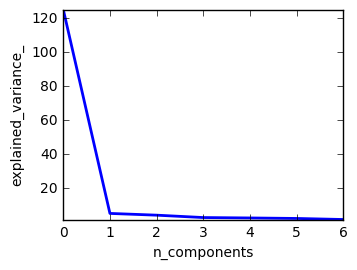

In [67]:
#Imprimimos el PCA y la varianza acorde al numero de componentes
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [68]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

In [69]:
#Hacemos KNN con los 7 componentes principales
KNN = KNeighborsClassifier(n_neighbors=3, weights="distance")
KNN.fit(x_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [70]:
pred_noprob = KNN.predict(x_test)
print("Resultado de Precisión del Modelo: {}".format(accuracy_score(y_test, pred_noprob)))

Resultado de Precisión del Modelo: 0.6084880636604775


Podemos ver que nuestro modelo de KNN&PCA tiene una precision de **~60%** en el cross-validation.

## Modelo final selecccionado: BOSQUES ALEATORIOS

Vamos a usar nuestro modelo de Bosques Aleatorios para predecir en el test original.

In [71]:
#Vamos a hacer dos predicciones, una con probabilidad y otra que nos de directamente la clase
predicciones = bosque.predict_proba(np.asarray(test))
predicciones_noProba = bosque.predict(np.asarray(test))

In [72]:
#Podemos ver las predicciones que tenemos, estas corresponden al tipo de viaje 
predicciones_noProba

array([22, 27, 37, ...,  5, 24, 17], dtype=int8)

In [73]:
#Vemos que tenemos 95,674 predicciones
len(predicciones_noProba)

95674

### Kaggle Submission

Para preparar nuestros datos antes de subirlos a Kaggle, usaremos la siguiente funcion:

In [74]:
def predictions_to_csv(test_predictions):
    test_predictions = pd.DataFrame(test_predictions)
    test_indexes = test.index
    test_predictions = test_predictions.rename(columns = {0:"TripType_3", 1: "TripType_4", 2: "TripType_5", 3: "TripType_6", 
                4: "TripType_7", 5: "TripType_8", 6: "TripType_9", 7: "TripType_12", 8: "TripType_14", 
                9: "TripType_15", 10: "TripType_18", 11: "TripType_19", 12: "TripType_20", 13: "TripType_21",
                14: "TripType_22", 15: "TripType_23", 16: "TripType_24", 17: "TripType_25", 18: "TripType_26", 
                19: "TripType_27", 20: "TripType_28", 21: "TripType_29", 22: "TripType_30", 23: "TripType_31", 
                24: "TripType_32", 25: "TripType_33", 26: "TripType_34", 27: "TripType_35", 28: "TripType_36", 
                29: "TripType_37", 30: "TripType_38", 31: "TripType_39", 32: "TripType_40", 33: "TripType_41", 
                34: "TripType_42", 35: "TripType_43", 36: "TripType_44", 37: "TripType_999"})
    test_predictions.insert(0, 'VisitNumber', test_indexes)
    return test_predictions.to_csv("sample_submission.csv", index=False)

In [75]:
#Aplicamos la funciones para generar sample_submission
predictions_to_csv(predicciones)

In [76]:
#Comprobamos se haya creado el .csv en el directorio
!ls

README.md                           sample_submission.csv
data                                walmart-trip-classifier-final.ipynb
kaggle-submission.png               walmart.png


## Sección 4. Conclusiones